In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output

# Data reading and cleaning

In [2]:
def read_LAI(year):
    df_LAI=pd.read_csv('Crop/IRI/FxMt_IRI-FL_'+str(year)+'_30m_01/FxMt_IRI-FL_'+str(year)+'_not_01.csv')
    df_LAI=df_LAI.drop(0,axis=0)
    df_LAI.index=pd.to_datetime(df_LAI['Unnamed: 0'])
    df_LAI=df_LAI.drop('Unnamed: 0',axis=1)
    df_LAI.columns=['LAI','PLTHT']
    df_LAI=df_LAI.astype(float)
    return df_LAI


def read_LAI_all():
    LAI=pd.read_csv('Crop/IRI/all_data_LAI'+'.csv').set_index('Unnamed: 0')
    LAI.index=pd.to_datetime(LAI.index)
    return LAI

def read_data(year):
    df_all=pd.read_csv('Crop/IRI/all_data_'+str(year)+'.csv')
    df_all=df_all.set_index('datetime')
    df_all.index=pd.to_datetime(df_all.index)
    return df_all


def read_data_all():
    df_all=pd.read_csv('Crop/IRI/all_data'+'.csv')
    df_all=df_all.set_index('datetime')
    df_all.index=pd.to_datetime(df_all.index)
    return df_all


def generate_array_dif(attrs_site, attr,level):
    dar = [0.25,0.25,.25]
    dar[level] = attrs_site[attr].values[0]
    return dar


def generate_array_same(attrs_site, attr):
    a = attrs_site[attr].values[0]
    return [a, a, a]


def modify_attr(df_state_init, df, name):

    all_attrs = pd.read_csv('all_attrs.csv')
    attrs_site = all_attrs[all_attrs.site == name]
    df_state_init.loc[:, 'emissionsmethod'] = 0
    df_state_init.loc[:,'roughlenheatmethod']=1
    

    if attrs_site.land.values[0] == 'DecTr':
        ar = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        level = 1
        df_state_init.albmin_dectr=attrs_site['albmin'].values[0]
        df_state_init.albmax_dectr=attrs_site['albmax'].values[0]
        df_state_init.albdectr_id=df_state_init.albmin_dectr
        df_state_init.loc[:, 'dectreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'EveTr':
        ar = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        level = 0
        df_state_init.albmin_evetr=attrs_site['albmin'].values[0]
        df_state_init.albmax_evetr=attrs_site['albmax'].values[0]
        df_state_init.albevetr_id=df_state_init.albmin_evetr
        df_state_init.loc[:, 'evetreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'Grass':
        ar = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        level = 2
        df_state_init.albmin_grass=attrs_site['albmin'].values[0]
        df_state_init.albmax_grass=attrs_site['albmax'].values[0]
        df_state_init.loc[:,'roughlenmommethod']=1
        df_state_init.albgrass_id=df_state_init.albmin_grass
        df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*.1
        df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*.7

    else:
        print('The land cover type is not found! using the default one')

    df_state_init.loc[:, 'sfr'] = ar
    df_state_init.loc[:, 'lat'] = df.Latitude.values[0].values[0]
    df_state_init.loc[:, 'lng'] = df.Longitude.values[0].values[0]
    df_state_init.loc[:, 'z'] = attrs_site.meas.values[0]
    df_state_init.loc[:, 'laimin'] = generate_array_dif(attrs_site, 'laimin',level)
    df_state_init.loc[:, 'laimax'] = generate_array_dif(attrs_site, 'laimax',level)
    df_state_init.loc[:, 'gddfull'] = generate_array_same(attrs_site, 'gddfull')
    df_state_init.loc[:, 'sddfull'] = generate_array_same(attrs_site, 'sddfull')
    df_state_init.loc[:, 'basete'] = generate_array_same(attrs_site, 'basete')
    df_state_init.loc[:, 'baset'] = generate_array_same(attrs_site, 'baset')
    df_state_init.lai_id = df_state_init.loc[:, 'laimin']
    
    
    

    return df_state_init,level


def func_parse_date(Year, DOY, hours, minutes):
        dt = pd.to_datetime(' '.join(
            [str(k) for k in [Year, DOY, hours, minutes]]),
            format='%Y %j %H %M')
        return dt

In [3]:
def to_SUEWS(year):
    df=pd.read_csv('Crop/IRI/FxMt_IRI-FL_'+str(year)+'_30m_01/FxMt_IRI-FL_'+str(year)+'_30m_01.csv')
    df=df.drop(0,axis=0)

    hours=[]
    minutes=[]
    for x in df.TIME:
        if len(x)==2:
            hour=0
            minute=int(x)
        elif len(x)==3:
            hour=int(x[0])
            minute=int(x[1:])
        elif len(x)==4:
            hour=int(x[0:2])
            minute=int(x[2:])
        if hour==24:
            hour=0
        hours.append(hour)
        minutes.append(minute)

    df['hours']=hours
    df['minutes']=minutes
    df.replace(' ',-99999,inplace=True)
    df=df.astype(float)
    #df=df.replace(-99999,np.nan)
    df['datetime']=df.apply(lambda x: func_parse_date(int(x['Year']),int(x.DOY),int(x.hours),int(x.minutes)),axis=1)
    df=df.set_index('datetime')

    df.replace(-99999,np.nan).to_csv('Crop/IRI/all_data_'+str(year)+'.csv')

    df_period=df

    df_period=df_period.replace(-99999,np.nan).resample('1h').mean().replace(np.nan,-99999)



    input_columns=['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH', 'Tair', 'pres', 'rain', 
    'kdown', 'snow', 'ldown', 'fcld', 'Wuh', 'xsmd', 'lai', 'kdiff', 'kdir', 'wdir']
    df_input=pd.DataFrame(columns=input_columns)
    df_input.iy=df_period.index.year
    df_input.id=[x.timetuple().tm_yday for x in df_period.index]
    df_input.it=df_period.index.hour
    df_input.imin=df_period.index.minute
    df_input['kdown']=df_period.Rg.values
    df_input['ldown']=df_period.Rgl.values
    df_input['U']=df_period.WS.values
    df_input['snow']=0
    df_input['rain']=0
    df_input['RH']=df_period.Rh.values
    df_input['Tair']=df_period.Ta.values
    df_input['pres']=101
    df_input['qf']=0
    df_input.qn=df_period.Rn.values


    df_input=df_input.replace(-99999,np.nan)

    for i in ['rain','U','RH','pres']:
        df_input.loc[df_input[df_input[i]<0].index,i]=-999

        df_input.loc[df_input[df_input['Tair']<-50].index,'Tair']=-999
    df_input.fillna(-999,inplace=True)


    name='IRI'
    df_input.to_csv('runs/data/'+name+'_'+str(year)+'_data_60.txt',sep=' ',index=0)
    return df_input

In [4]:
name='IRI'

In [5]:
df_all_2013=read_data(2013)
df_all_2014=read_data(2014)
df_all=pd.concat([df_all_2013,df_all_2014])
df_all.to_csv('Crop/IRI/all_data'+'.csv')

In [6]:
df_input_2013=to_SUEWS(2013)
df_input_2014=to_SUEWS(2014)
df_input=pd.concat([df_input_2013,df_input_2014])
df_input.to_csv('runs/data/'+name+'_'+'all'+'_data_60.txt',sep=' ',index=0)

In [7]:
df_LAI_2013=read_LAI(2013)
df_LAI_2014=read_LAI(2014)
pd.concat([df_LAI_2013,df_LAI_2014]).to_csv('Crop/IRI/all_data_LAI'+'.csv')

# LAI (Necessary for soil to find the soil period of crop land)

In [8]:
def cal_LAI_model(year,p1,p2):

    df_all= read_data_all()
    sub_df=df_all.loc[p1:p2]
    sub_df.index=pd.to_datetime(sub_df.index)
    filled=sp.util.fill_gap_all(sub_df.Ta)
    sub_df.Ta=filled
    GDD_s=0.5*(sub_df.Ta.resample('1D').max()+sub_df.Ta.resample('1D').min())
    GDD_s.loc[:p1]=0
    b=GDD_s.cumsum()

    lai_min=0.5
    lai_max=7
    slope=0.00468
    slope=(lai_max-lai_min)*(0.00118)/(2.25-0.5)
    
    start_GDD=475
    lai=(b-start_GDD)*slope+lai_min
    
    lai[lai>lai_max]=lai_max
    lai[b<start_GDD]=lai_min
    sec_gdd=b[lai[lai==lai_max].index]
    lai.loc[lai[lai==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*slope
    lai[lai<lai_min]=lai_min
    return lai


def run_model_alb(year,p1,p2,name,lai_model):
    copyfile('runs/data/'+name+'_'+'all'+'_data_60.txt',
             "runs/run1/input/Kc_2012_data_60.txt")

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run1' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)



    df_forcing_run_2=df_forcing_run.loc[p1:p2]
    lai_sub=lai_model
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                            df_state_init,
                                            save_state=False)

    return df_output,grid,df_forcing_run_2


In [9]:
year=2013
name='IRI'
if year==2014:
    p1=str(year-1)+' 12 02'
    p2=str(year)+' 03 15'
elif year==2013:
    p1=str(year)+' 06 27'
    p2=str(year)+' 10 21'
    
    
lai_model=cal_LAI_model(year,p1,p2)
df_LAI=read_LAI_all()
LAI_obs=df_LAI.LAI.dropna().loc[p1:p2]
df_output,grid,df_forcing=run_model_alb(year,p1,p2,name,lai_model)

2020-01-31 14:44:53,119 — SuPy — INFO — All cache cleared.
2020-01-31 14:44:55,624 — SuPy — INFO — All cache cleared.
2020-01-31 14:44:57,183 — SuPy — INFO — ====================
2020-01-31 14:44:57,184 — SuPy — INFO — Simulation period:
2020-01-31 14:44:57,185 — SuPy — INFO —   Start: 2013-06-27 00:00:00
2020-01-31 14:44:57,186 — SuPy — INFO —   End: 2013-10-21 23:55:00
2020-01-31 14:44:57,187 — SuPy — INFO — 
2020-01-31 14:44:57,189 — SuPy — INFO — No. of grids: 1
2020-01-31 14:44:57,190 — SuPy — INFO — SuPy is running in serial mode
2020-01-31 14:45:05,035 — SuPy — INFO — Execution time: 7.9 s
2020-01-31 14:45:05,036 — SuPy — INFO — ====================



# Functions related to irrigation and evaporations

In [10]:
from gs_util import IQR_compare,obs_sim

def irr_mod(df_state_init,df_forcing_run_2,year):
    df_state_init.loc[:,'surfacearea']=1
    df_state_init.loc[:,'waterusemethod']=1
    df_state_init.loc[:,'irrfracgrass']=1
    df_state_init.loc[:,'statelimit']=[0.48,0.25,1.3,0.8,   30  ,1.0,30000.0]
    df_state_init.loc[:,'wetthresh']=[0.48,0.25,1.3,0.8,   30  ,1.0,0.5]
    df_forcing_run_2.Wuh=0
    temp=df_forcing_run_2[df_forcing_run_2.index.hour>22]
    df_forcing_run_2.loc[temp.index,'Wuh']=(1*10000)*(3/100)
    if year==2013:
        df_forcing_run_2.loc[str(year)+' 10 7':,'Wuh']=0
    elif year ==2014:
        df_forcing_run_2.loc[str(year)+' 3 1':,'Wuh']=0
    return df_state_init,df_forcing_run_2



def modify_attr_2(df_state_init,g_max,s1):
    df_state_init.maxconductance=g_max
    df_state_init.s1=s1
    return df_state_init

def run_model_evap(tp,coef,lai_model,d1,d2,d3,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1):

    copyfile('runs/data/'+name+'_'+'all'+'_data_60.txt',
         "runs/run1/input/Kc_2012_data_60.txt")
    
    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })    
    
    path_runcontrol = Path('runs/run1'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    df_forcing_run=df_forcing_run.rename(columns={'wuh':'Wuh'})
    df_state_init,df_forcing_run=irr_mod(df_state_init,df_forcing_run,year)
    
    a=df_state_init.loc[:,'ohm_coef'].values[0]
    
    for i in [0,1,2,3]:
        s=4
        a[(s)*4*3+((i)*3)+(0)]=coef[0]
        a[(s)*4*3+((i)*3)+(1)]=coef[1]
        a[(s)*4*3+((i)*3)+(2)]=coef[2]

    df_state_init.loc[:,'ohm_coef']=a
    
    
    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai_model
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    bb=lai_sub[lai_sub<3]
    lai_sub.loc[bb.index]=7

    
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')
    
    
    df_forcing_run_2.qn=sp.util.fill_gap_all(df_forcing_run_2.qn.replace(-999,np.nan))
    
    a=df_forcing_run_2[df_forcing_run_2.ldown<0]
    df_forcing_run_2.loc[a.index,'ldown']=-999
    df_forcing_run_2.ldown=sp.util.fill_gap_all(df_forcing_run_2.ldown.replace(-999,np.nan))

    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]    

    df_state_init.g1=g1*alpha
    df_state_init.g2=g2
    df_state_init.g3=g3
    df_state_init.g4=g4
    df_state_init.g5=g5
    df_state_init.g6=g6
    df_state_init.loc[:,'netradiationmethod']=0

    
    df_state_init=modify_attr_2(df_state_init,g_max,s1)
    
    if tp=='soil':
        df_forcing_run_2=df_forcing_run_2.loc[d1:d3]
        df_state_init.lai_id = 7
    else:
        df_forcing_run_2=df_forcing_run_2.loc[d3:d2]
    
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)

    

    return df_output, df_state_init,df_forcing_run_2

# gs Calibration

## Some necessary functions for gs calculations

In [11]:
from gs_util import cal_gs_obs,cal_gs_mod
from atmosp import calculate as ac
def cal_des_dta(ta, pa, dta=1.0):
    """Calculate slope of es(Ta), i.e., saturation evaporation pressure `es` as function of air temperature `ta [K]`
    Parameters
    ----------
    ta : numeric
        Air temperature [K]
    pa : numeric
        Air pressure [Pa]
    dta : float, optional
        change in ta for calculating that in es, by default 1.0 K
    """

    des = ac('es', p=pa, T=ta + dta/2) - ac('es', p=pa, T=ta - dta/2)
    des_dta = des/dta
    try:
        # try to pack as Series
        des_dta = pd.Series(des_dta, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass
    return des_dta


def cal_rs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface resistance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        sensible heat flux [W m-2]
    qe : numeric
        latent heat flux [W m-2]
    ta : numeric
        air temperature [K]
    rh : numeric
        relative humidity [%]
    pa : numeric
        air pressure [Pa]
    Returns
    -------
    numeric
        Surface resistance based on observations [s m-1]
    """

    # surface resistance at water surface [s m-1]
    #rav = 100
    rav=RA

    # psychrometric constant [Pa K-1] as a function of air pressure
    ser_gamma = 0.665e-3 * pa

    # air density [kg m-3]
    val_rho = 1.27

    # heat capacity of air [J kg-1 K-1]
    val_cp = 1005

    # slope of es(Ta) curve at Ta
    ser_des_dTa = cal_des_dta(ta, pa, dta=1.0)
    #
    arr_e = ac('e', p=pa, T=ta, RH=rh)
    arr_es = ac('es', p=pa, T=ta)
    arr_vpd = arr_es-arr_e
    #
    ser_rs_1 = ((ser_des_dTa / ser_gamma)*(qh / qe) - 1) * rav
    ser_rs_2 = (val_rho * val_cp * arr_vpd / (ser_gamma * qe))
    ser_rs = ser_rs_1 + ser_rs_2

    try:
        # try to pack as Series
        ser_rs = pd.Series(ser_rs, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass

    return ser_rs,ser_rs_1,ser_rs_2,ser_des_dTa,((ser_des_dTa / ser_gamma)*(qh / qe) - 1),arr_vpd 







def cal_gs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface conductance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        Sensible heat flux [W m-2]
    qe : numeric
        Latent heat flux [W m-2]
    ta : numeric
        Air temperature [K]
    rh : numeric
        Relative humidity [%]
    pa : numeric
        Air pressure [Pa]
    Returns
    -------
    numeric
        Surface conductance based on observations [mm s-1]
    """
    rs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd = cal_rs_obs(qh, qe, ta, rh, pa,RA)
    gs_obs = 1e3/rs_obs
    return gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd

In [12]:
year=2014
name='IRI'
if year==2014:
    p1=str(year-1)+' 12 02'
    p2=str(year)+' 03 15'
    p3=str(year)+' 01 5'
elif year==2013:
    
    p1=str(year)+' 06 27'
    p2=str(year)+' 10 21'
    p3=str(year)+' 08 01'
    #p2=str(year)+' 08 15'

    
tp='soil'
#tp='crop'
# some initial vlaues based on the crop calculations
if tp=='soil':
    if year==2013:
        coef=[ 0.47,  0.102, -20.4]
    elif year==2014:
        coef=[ 0.38,  0.102, -24.4]

    g_max=419.45872285126813
    s1=5.56
    alpha=0.34
    g1=0.367
    g2=104.713
    g3=0.192
    g4=0.568
    g5=36.46
    g6=0.049
else:

    coef=[ 0.42,  0.045, -15.4]

    g_max=419.45872285126813
    s1=5.56
    alpha=0.7
    g1=0.367
    g2=104.713
    g3=0.192
    g4=0.568
    g5=36.46
    g6=0.049
    
lai_model=cal_LAI_model(year,p1,p2)
df_output, df_state_init,df_forcing_run_2=run_model_evap(tp,coef,lai_model,p1,p2,p3,
                                                         g1,g2,g3,g4,g5,g6,
                                                         g_max,s1,name,year,
                                                         alpha=alpha)




lai_model=cal_LAI_model(year,p1,p2)
df_output, df_state_init,df_forcing_run_2=run_model_evap(tp,coef,lai_model,p1,p2,p3,
                                                         g1,g2,g3,g4,g5,g6,
                                                         g_max,s1,name,year,
                                                         alpha=alpha)

2020-01-31 14:47:19,944 — SuPy — INFO — All cache cleared.
2020-01-31 14:47:20,753 — SuPy — INFO — All cache cleared.
2020-01-31 14:47:22,566 — SuPy — INFO — ====================
2020-01-31 14:47:22,567 — SuPy — INFO — Simulation period:
2020-01-31 14:47:22,568 — SuPy — INFO —   Start: 2013-12-02 00:00:00
2020-01-31 14:47:22,569 — SuPy — INFO —   End: 2014-01-05 23:55:00
2020-01-31 14:47:22,569 — SuPy — INFO — 
2020-01-31 14:47:22,571 — SuPy — INFO — No. of grids: 1
2020-01-31 14:47:22,573 — SuPy — INFO — SuPy is running in serial mode
2020-01-31 14:47:24,593 — SuPy — INFO — Execution time: 2.0 s
2020-01-31 14:47:24,594 — SuPy — INFO — ====================

2020-01-31 14:47:24,833 — SuPy — INFO — All cache cleared.
2020-01-31 14:47:25,733 — SuPy — INFO — All cache cleared.
2020-01-31 14:47:28,105 — SuPy — INFO — ====================
2020-01-31 14:47:28,106 — SuPy — INFO — Simulation period:
2020-01-31 14:47:28,107 — SuPy — INFO —   Start: 2013-12-02 00:00:00
2020-01-31 14:47:28,107 — S

In [14]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()

df_forcing=pd.read_csv('runs/run1'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

df_forcing= df_forcing.set_index('datetime')

df_all= read_data_all().resample('1h').mean()
if tp=='soil':
    df_an=df_all.loc[p1:p3]
    df_forcing=df_forcing.loc[p1:p3]
else:
    df_an=df_all.loc[p3:p2]
    df_forcing=df_forcing.loc[p1:p3]
    
df_an.index=pd.to_datetime(df_an.index)


df_forcing.qe=df_an.LE
df_forcing.qh=df_an.H


calculate the mimimum and maximum limit for calibrations

In [15]:
g6max=5.56/df.SMD.max()
g6max

2.033057443542189

In [16]:
g6min=5.56/150
g6min

0.037066666666666664

In [17]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[(df_forcing.qe > 0)&(df_forcing.qe < 900)]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,vpd = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)

df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

In [18]:
g_max=np.percentile(gs_obs,100)
s1=5.56
g_max

40.385579352129994

In [19]:
df_forcing=df_forcing[gs_obs<g_max]
lai_max=df_state_init.laimax.loc[grid,:][2]
gs_obs=gs_obs[gs_obs<g_max]

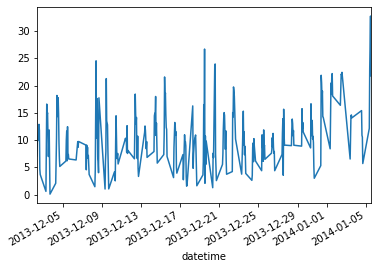

In [20]:
gs_obs.plot()

In [21]:
lai_max

7.0

## Optimization part

More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [29]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os

df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [30]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

In [31]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [32]:
problem = Problem(6,2,1)
problem.types[0] = Real(.1, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(g6min, 0.05)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
#algorithm=NSGAIII(problem, divisions_outer=12)
algorithm.run(3000)


In [33]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.344	0.601
0.349	0.585
0.533	0.350
0.593	0.335
0.365	0.548
0.359	0.555
0.419	0.454
0.353	0.573
0.442	0.420
0.371	0.533


Text(0, 0.5, 'objective 2')

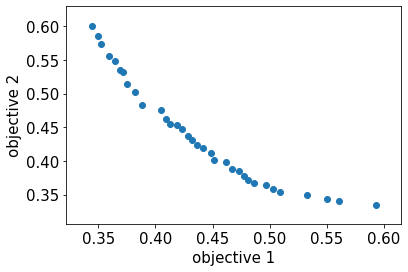

In [34]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

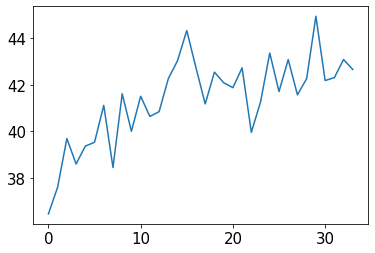

In [35]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [36]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

In [37]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.43231838215741414
0.43059841264959825


In [38]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [39]:
with open('g1-g6/'+name+'-'+tp+'-g1-g6','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [40]:
with open('g1-g6/'+name+'-'+tp+'-g1-g6','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [41]:
pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
IRI,0.453,108.938,0.935,0.962,42.266,0.041


# Testing using the calibrated parameters

In [47]:
year=2013
name='IRI'
if year==2014:
    p1=str(year-1)+' 12 02'
    p2=str(year)+' 03 15'
    p3=str(year)+' 01 5'
elif year==2013:
    
    p1=str(year)+' 06 27'
    p2=str(year)+' 10 21'
    p3=str(year)+' 08 01'
    #p2=str(year)+' 08 15'

    
tp='soil'

coef=[ 0.47,  0.102, -20.4] # tuned to be the best QS fit



g_max=g_max
s1=5.56

# alpha needs to be tuned iteratively
alpha=0.6
g1=g1
g2=g2
g3=g3
g4=g4
g5=g5
g6=g6

lai_model=cal_LAI_model(year,p1,p2)
df_output, df_state_init,df_forcing_run_2=run_model_evap(tp,coef,lai_model,p1,p2,p3,
                                                         g1,g2,g3,g4,g5,g6,
                                                         g_max,s1,name,year,
                                                         alpha=alpha)

2019-12-16 11:56:53,904 — SuPy — INFO — All cache cleared.
2019-12-16 11:56:54,721 — SuPy — INFO — All cache cleared.
2019-12-16 11:56:56,796 — SuPy — INFO — ====================
2019-12-16 11:56:56,797 — SuPy — INFO — Simulation period:
2019-12-16 11:56:56,798 — SuPy — INFO —   Start: 2013-06-27 00:00:00
2019-12-16 11:56:56,799 — SuPy — INFO —   End: 2013-08-01 23:55:00
2019-12-16 11:56:56,800 — SuPy — INFO — 
2019-12-16 11:56:56,802 — SuPy — INFO — No. of grids: 1
2019-12-16 11:56:56,804 — SuPy — INFO — SuPy is running in serial mode
2019-12-16 11:56:58,956 — SuPy — INFO — Execution time: 2.2 s
2019-12-16 11:56:58,957 — SuPy — INFO — ====================



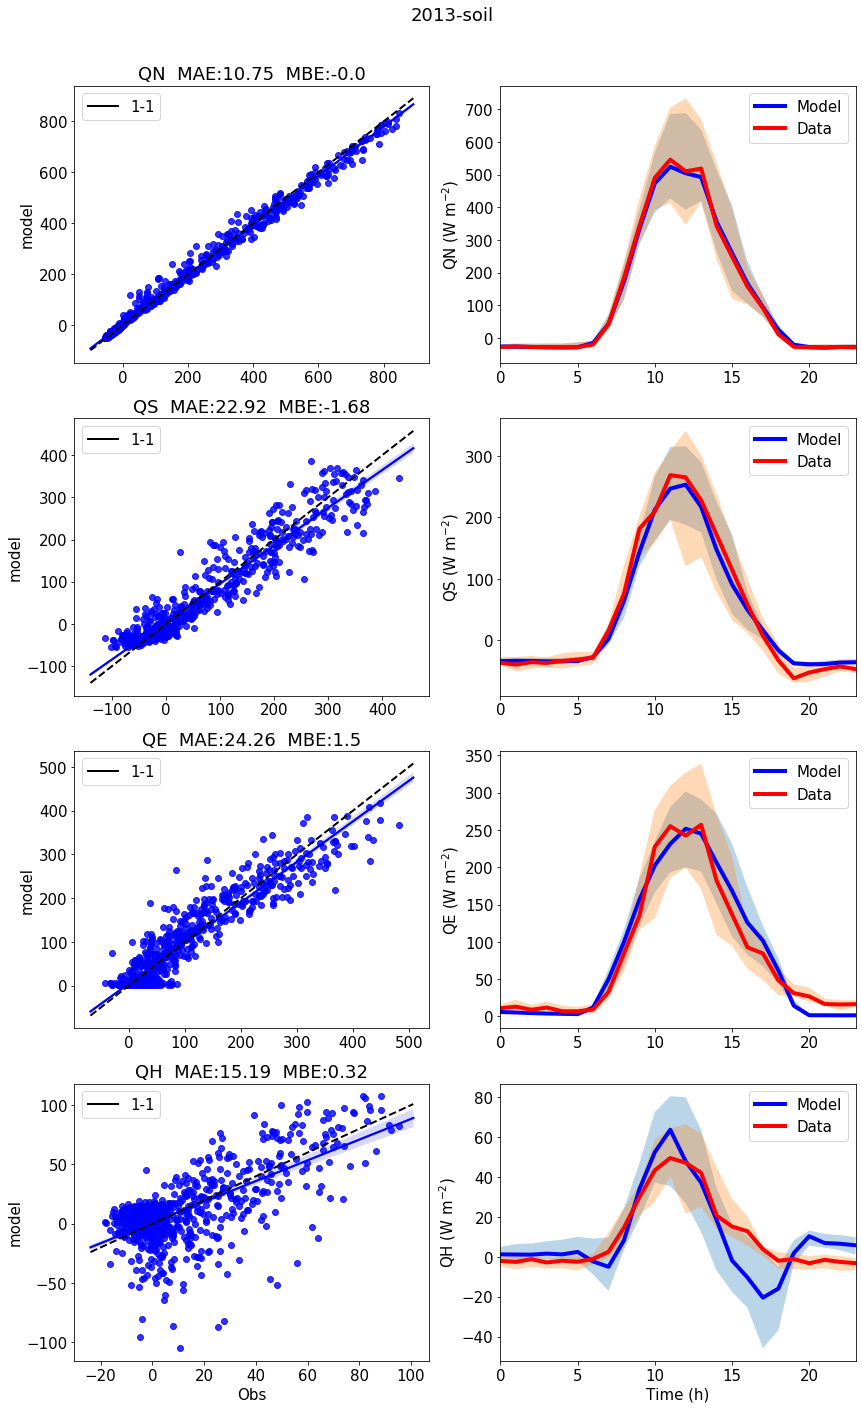

In [48]:
df_all= read_data_all().resample('1h').mean()
if tp=='soil':
    df_an=df_all.loc[p1:p3]
else:
    df_an=df_all.loc[p3:p2]
df_an.index=pd.to_datetime(df_an.index)
df_an=df_an

out=df_output.SUEWS.loc[grid]

out=out.resample('1h',closed='left',label='right').mean()

df_an['qs']=df_an.Rn-df_an.LE-df_an.H


var_meas=['Rn','qs','LE','H']
var_model=['QN','QS','QE','QH']

fig,axs=plt.subplots(len(var_meas),2,figsize=(14,22))
plt.rc('font', size=15)
fig.suptitle(str(year)+'-'+tp)
fig.subplots_adjust(top=0.93)

counter=-1
for varmeas,varmodel in zip(var_meas,var_model):
    counter=counter+1
    
    meas=df_an[varmeas].dropna()
    

    ax=axs[counter][0]
    temp=df_an.loc[meas.index]
    aa=out.loc[temp.index][varmodel].dropna()
    obs_sim(varmeas,varmodel,temp.loc[aa.index],out.loc[aa.index],ax)
    ax.set_ylabel('model')
    
    MAE=np.round(np.mean(abs(temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)
    MBE=np.round(np.mean((temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)

    if counter==len(var_model)-1:
        ax.set_xlabel('Obs')
    ax.set_title(varmodel+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))
    
    ax=axs[counter][1]
    IQR_compare(varmeas,varmodel,temp,out.loc[temp.index],ax)
    ax.legend()
    if counter==len(var_model)-1:
        ax.set_xlabel('Time (h)')
    ax.set_ylabel(varmodel+' (W m$^{-2}$)')
# plt.savefig('IRI-SEB-'+tp+'-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# Writing to pcike files

In [49]:
with open('g1-g6/'+'soil'+'-g','wb') as f:
    pickle.dump([g_max,alpha,g1,g2,g3,g4,g5,g6], f)

In [53]:
all_data={}
all_data['model']=out.QE
all_data['obs']=df_an.LE
with open('surface_conductance/'+'soil-phil-'+str(year),'wb') as f:
    pickle.dump(all_data, f)